In [2]:
import sys ,os, importlib
import pandas as pd
import configparser
import matplotlib.pyplot as plt
import cv2

p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

import data_processing.data_processing_functions as DP
import utils as Utils
importlib.reload(Utils)

config = configparser.ConfigParser()
config.read("../../config.ini")
pd.set_option('display.max_colwidth', None)

In [3]:
CLEANED_CNCB_PATH = config['PATHS']['CLEANED_CNCB_PATH']
CLEANED_CNCB_IMAGES_PATH = os.path.join(CLEANED_CNCB_PATH, "dataset_cleaned")
CLEANED_CNCB_MASKS_PATH = os.path.join(CLEANED_CNCB_PATH, "dataset_seg")


In [4]:
images_metadata_list = []
for categ in os.listdir(CLEANED_CNCB_IMAGES_PATH):
    categ_path = os.path.join(CLEANED_CNCB_IMAGES_PATH, categ)
    for folder in os.listdir(categ_path):
        folder_path = os.path.join(categ_path, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            for img in os.listdir(file_path):
                if img.endswith(".png"):
                    img_path = os.path.join(file_path, img)
                    images_metadata_list.append([img_path, categ, folder, file, img])

images_metadata_df = pd.DataFrame(images_metadata_list, columns=["image_path", "category", "patient", "scan", "img"])
images_metadata_df.head()

,image_path,category,patient,scan,img
0,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0079.png,Normal,2118,573,0079.png
1,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0016.png,Normal,2118,573,0016.png
2,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0025.png,Normal,2118,573,0025.png
3,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0042.png,Normal,2118,573,0042.png
4,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0076.png,Normal,2118,573,0076.png


In [6]:
#convert patient column to int
images_metadata_df["patient"] = images_metadata_df["patient"].astype(int)
# get the min and the max of the patient column windowed by category
images_metadata_df.groupby("category")["patient"].agg(["min", "max"])

,min,max
category,,
CP,0,4044
NCP,16,3999
Normal,742,3916


In [5]:
print(images_metadata_df.shape)
print(f"Distinct patient: {images_metadata_df.groupby(['patient']).ngroups}")
print(f"Total number of scans : {images_metadata_df.groupby(['patient', 'scan']).ngroups}")
print("Imgs per category:")
images_metadata_df.groupby(['category']).size()

(397943, 5)
Distinct patient: 2698
Total number of scans : 4034
Imgs per category:


category
CP        157939
NCP       152790
Normal     87214
dtype: int64

In [7]:
masks_metadata_list = []
for categ in os.listdir(CLEANED_CNCB_MASKS_PATH):
    categ_path = os.path.join(CLEANED_CNCB_MASKS_PATH, categ)
    for folder in os.listdir(categ_path):
        folder_path = os.path.join(categ_path, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            for mask in os.listdir(file_path):
                if mask.endswith(".png"):
                    mask_path = os.path.join(file_path, mask)
                    masks_metadata_list.append([mask_path, categ, folder, file, mask])
mask_metadata_df = pd.DataFrame(masks_metadata_list, columns=["mask_path", "category", "patient", "scan", "img"])

In [8]:
print(mask_metadata_df.shape)
print(f"Distinct patient: {mask_metadata_df.groupby(['patient']).ngroups}")
print(f"Total number of scans : {mask_metadata_df.groupby(['patient', 'scan']).ngroups}")

(397665, 5)
Distinct patient: 2698
Total number of scans : 4034


In [51]:
# join the image and the mask metadata df
metadata_df = images_metadata_df.merge(mask_metadata_df, on=["category", "patient", "scan", "img"], how="inner")
print(metadata_df.shape)
metadata_df.head(2)

(397665, 6)


,image_path,category,patient,scan,img,mask_path
0,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0079.png,Normal,2118,573,0079.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0079.png
1,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0016.png,Normal,2118,573,0016.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0016.png


# Sample

    values   count
0        0  181976
1       37    1264
2       38     845
3       39     459
4       40     681
5       41     785
6       42     845
7       43     665
8       44     956
9       45    1008
10      46     820
11      47    1040
12      48    1119
13      49     940
14      50    1196
15      51    1283
16      52    1200
17      53    1038
18      54    1270
19      55    1312


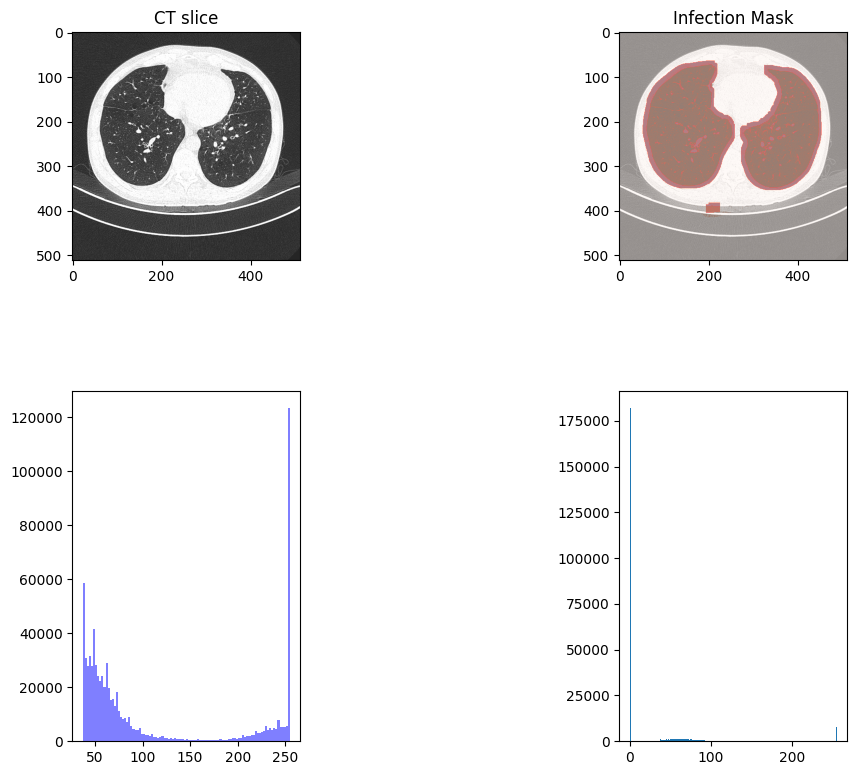

In [63]:
meta_sample = metadata_df.sample(1)
for _, row in meta_sample.iterrows():
    img = cv2.imread(row["image_path"])
    mask = cv2.imread(row["mask_path"], cv2.IMREAD_UNCHANGED)
    print(Utils.get_hist_as_df(mask).head(20))
    Utils.plot_ct_slice_with_hist(img, infection_mask=mask)
